# Exploring the Effect of Collaborative Filtering on Gender Bias Disparity in Last-FM Listening Events - Experiment 1

Author: Dougal Shakespeare

>Analysis of gender distribution achieved by merging the LFM-1b dataset consisting of Last FM listening histories with artist gender meta-data found in a local config of the MusicBrainz db. The metric of bias-disparity is utalised to assess relative increases in biases towards item categories (in this case gender) subsequent to the production of music recommendations through CF methodologies. 

## Experiment 1: Real Life Scenario - Random Sample From Last-fm Datasets

In [1]:
import random as rd
import pandas as pd
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats
from surprise import AlgoBase
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import KFold
import random
import os.path
import requests
import re
import os
import h5py
from scipy import sparse
import csv
import random

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

In [2]:
base_path = '/media/dshakes/Elements1/lastfm-dataset-360K_0.2/lastfm-dataset-360K/' #todo: change to be data before submitting

lfm1b_le75_path = base_path + 'baseline-data/LastFM360k-Le75.txt'
lastfm360k_le75_artists_path = base_path + 'baseline-data/artists-LastFM360k-le75.csv'
lastfm460k_le75_users_path = base_path + 'baseline-data/users-LastFM360k-le75.csv'

In [3]:
cols = ['user', 'artist', 'playcount']
df_events = pd.read_csv(lfm1b_le75_path, names=cols)

artist_mat_le75_df = pd.read_csv(lastfm360k_le75_artists_path)
user_mat_le75_df = pd.read_csv(lastfm460k_le75_users_path)

FileNotFoundError: [Errno 2] File /media/dshakes/Elements1/lastfm-dataset-360K_0.2/lastfm-dataset-360K/baseline-data/LastFM360k-Le75.txt does not exist: '/media/dshakes/Elements1/lastfm-dataset-360K_0.2/lastfm-dataset-360K/baseline-data/LastFM360k-Le75.txt'

In [5]:
# User gender distribution analysis
def compute_user_gender_dist(df_u):
    user_m = df_u[df_u.gender == 'm']
    user_f = df_u[df_u.gender == 'f']
    user_u = df_u[df_u.gender == 'n']
    return user_m, user_f, user_u

def compute_artist_gender_dist(df_a):
    artist_u = df_a[df_a.identified_gender == 0]
    artist_m = df_a[df_a.identified_gender == 1]
    artist_f = df_a[df_a.identified_gender == 2]
    artist_o = df_a[df_a.identified_gender == 3]
    artist_na = df_a[df_a.identified_gender == 4] 
    return artist_u, artist_m, artist_f, artist_o, artist_na

In [6]:
# Gender distribution analysis - artists
artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(artist_mat_le75_df)
user_m, user_f, user_u = compute_user_gender_dist(user_mat_le75_df)

### Preference ratio
We now compute preference ratios and bias disparity as based on the following methodolgy defined in: https://deepai.org/publication/crank-up-the-volume-preference-bias-amplification-in-collaborative-recommendation

$$P R_{S}(G, C)=\frac{\sum_{u \in G} \sum_{i \in C} S(u, i)}{\sum_{u \in G} \sum_{i \in I} S(u, i)}$$


In [7]:
def create_dynamic_dict_list(l):
    return [{} for _ in range(l)]

In [8]:
# preference ratio computation - G = user group, C = item category
def compute_pref_ratio(G, C, s_df):
    s_c = 0
    s_i = 0
    #print(G)
    for u in G:
        # filter to get the artists which the user listens to of category C
        filt_artists = s_df[s_df['user'] == u]
        filt_artists_c = filt_artists[filt_artists['artist'].isin(C)]
        s_c += len(filt_artists_c)
        s_i += len(filt_artists)
    return s_c/s_i

### Bias Disparity
$$B D(G, C)=\frac{P R_{R}(G, C)-P R_{S}(G, C)}{P R_{S}(G, C)}$$

In [9]:
def compute_bias_disparity(prR, prS):
    return (prR - prS) / prS

### Recommendation Functions

In [10]:
## Util functions

# Return top 10 item recommendations from algo predictions 
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def get_top_n_random(t, n=10):
    t_df = pd.DataFrame(testset, columns =['user', 'artist', 'playcount'])
    a_list = t_df['artist'].unique()

    top_n = defaultdict(list)
    for uid, iid, true_r in t:
        if len(top_n[uid]) == 0:
            for i in range(0, 10):
                # generate 10 recommendations for each user
                top_n[uid].append((rd.choice(a_list), i))
    return top_n

def get_top_n_mp(testset, item_dis, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for iid, count in item_dis[:n].items():
                top_n[uid].append((iid, count))
                
    #print('topn length:', len(top_n))
    return top_n

# Store predictions in csv file to be retirved after 
def predictions_to_csv(algorithm, k, dict_data, path): 
    # save as csv with algorithm and k fold num.
    csv_file = path + algorithm + str(k) + '.csv'
    
    if os.path.isfile(csv_file) == False:
        try:     
            with open(csv_file, 'w+', newline="") as csvfile:
                writer = csv.writer(csvfile)                
                for user_id, artist_recs in dict_data:
                    for artist in artist_recs:
                        writer.writerow([user_id, artist])
        except IOError:
            print("I/O error")
    else: print ('csv file allready exists')
        
def test_set_to_csv(algorithm, k, testset, path):
    path = path + algorithm + str(k) + '-testset' + '.csv'
    with open(path,'w+') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['user_id','artist', 'playcount'])
        for row in testset:
            csv_out.writerow(row)

def train_set_to_csv(algorithm, k, trainset, path):
    path = path + algorithm + str(k) + '-trainset' + '.csv'
    with open(path,'w+') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['user_id','artist', 'playcount'])
        for uid, iid, rating in trainset.all_ratings():
            #print('uid:{}, iid:{}, rating:{}'.format(uid, iid, rating))
            csv_out.writerow([uid, iid, rating])

In [11]:
# preference ratio computation - G = user group, C = item category
def compute_pref_ratio_recs(G, C, alg_recs):
    s_c = 0
    s_i = 0

    for u in G:
        # filter to get the artists which the user listens to of category C
        filt_artists = alg_recs[alg_recs.user_id == u]
        filt_artists_c = filt_artists[filt_artists.rec_artist.isin(C)]
        s_c += len(filt_artists_c)
        s_i += len(filt_artists)
    
    if (s_i == 0):
        return 0
    else: return s_c/s_i

### Experiment 1: Real data from LFM-1b
The following results were run in Google colab as the RAM is larger than on my machine.

In [12]:
#scaled_le_path = '/media/dshakes/Elements1/LFM1b/Experiment1/Data/lfm-1b-sample-sixth-scaled.csv'
results_folder = './expr1-360k/'
num_folds = 3

sample_dir = results_folder
complete_mf_sample_path = sample_dir + 'lastfm360k-mf-sample.csv'
scaled_mf_sample_path = sample_dir + 'lastfm360k-mf-sample-scaled.csv'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

#sample_df_events = pd.read_csv(scaled_le_path)

### 1. Sample

In [14]:
## (1) sample only male and female users and artists

samples_filtered = []
sampling_random = True #todo: change to not sampling strat

m_user_ids_sample = user_m['user_id'].values
f_user_ids_sample = user_f['user_id'].values
users_mf = [y for x in [m_user_ids_sample, f_user_ids_sample] for y in x] #male and female users

male_artist_ids = artist_m['id'].unique()
female_artist_ids = artist_f['id'].unique()
artist_sample = [y for x in [male_artist_ids, female_artist_ids] for y in x]

#sample_size = int(len(users_mf) * 0.3)
sample_size = 2000

# sample half
s = random.sample(range(0, len(users_mf)), sample_size)

user_sample = []

print('sampling!')
# randomly sample half the users in index range
for i in s:
    sampled_user = users_mf[i]
    user_sample.append(sampled_user)
    
sample_df = df_events[(df_events.user.isin(user_sample) & (df_events.artist.isin(artist_sample)))]
sample_df.to_csv(complete_mf_sample_path, index = False)

sampling!


In [19]:
## Compute input preference ratios

s_df_events = pd.read_csv(complete_mf_sample_path)

# initialise to be filled
pref_ratio_results = np.zeros((2,2))
pref_ratio_data = {}

# user/artist preference labels
names = ['m/m', 'm/f',
         'f/m', 'f/f']

user_ids = s_df_events.user.unique()
artist_ids = s_df_events.artist.unique()

m_user_ids = list(set(user_ids) & set(user_m.user_id))
f_user_ids = list(set(user_ids) & set(user_f.user_id))
m_artist_id = list(set(artist_ids) & set(artist_m.id))
f_artist_id = list(set(artist_ids) & set(artist_f.id))

male_user_interactions = s_df_events[s_df_events.user.isin(m_user_ids)]
male_user_artist_ids = male_user_interactions.artist.unique()

female_user_interactions = s_df_events[s_df_events.user.isin(f_user_ids)]
female_user_artist_ids = female_user_interactions.artist.unique()

m_m_interactions = male_user_interactions[male_user_interactions.artist.isin(m_artist_id)]
m_f_interactions = male_user_interactions[male_user_interactions.artist.isin(f_artist_id)]

f_m_interactions = female_user_interactions[female_user_interactions.artist.isin(m_artist_id)]
f_f_interactions = female_user_interactions[female_user_interactions.artist.isin(f_artist_id)]

pref_ratio_results[0,0] = len(m_m_interactions)/len(male_user_interactions)
pref_ratio_data['m/m'] = pref_ratio_results[0,0]

pref_ratio_results[0,1] = len(f_m_interactions)/len(female_user_interactions)
pref_ratio_data['f/m'] = pref_ratio_results[0,1]

pref_ratio_results[1,0] = len(m_f_interactions)/len(male_user_interactions)
pref_ratio_data['m/f'] = pref_ratio_results[1,0]

pref_ratio_results[1,1] = len(f_f_interactions)/len(female_user_interactions)
pref_ratio_data['f/f'] = pref_ratio_results[1,1]

print('--STATS FOR USER - ITEM INTERACTIONS IN SAMPLE--\n')
                                     
print('total number of users', len(user_ids))
print('total number of male users:', len(m_user_ids))
print('total number of female users:', len(f_user_ids))
print('total number of artists', len(artist_ids))
print('total number of male artists:', len(m_artist_id))
print('total number of female artists:', len(f_artist_id))

print('\n--Sparsity of user-item interactions--')

print('\nmale user - arist interactions', len(male_user_interactions))
print('sparsity of male user interactions: {} / {}'.format(len(male_user_artist_ids), len(male_user_artist_ids)/len(artist_ids)))
print('sparsity of female user interactions: {} / {}'.format(len(female_user_artist_ids), len(female_user_artist_ids)/len(artist_ids)))

print('\n--Input preference ratios for user-item interactions--')

print('\nmale user - male arist interactions: {} / {}'.format(len(m_m_interactions), pref_ratio_results[0,0]))
print('male user - female arist interactions: {} / {}'.format(len(m_f_interactions), pref_ratio_results[1,0]))

print('\nnumber of female user - artist interactions',len(female_user_interactions))
print('female user - male arist interactions: {} / {}'.format(len(f_m_interactions), pref_ratio_results[0,1]))
print('female user - female arist interactions: {} / {}\n'.format(len(f_f_interactions),pref_ratio_results[1,1]))

print('\n--Final Input pref ratio matrix--\n')
print(pref_ratio_results)

--STATS FOR USER - ITEM INTERACTIONS IN SAMPLE--

total number of users 1937
total number of male users: 1486
total number of female users: 451
total number of artists 13034
total number of male artists: 11116
total number of female artists: 1918

--Sparsity of user-item interactions--

male user - arist interactions 46947
sparsity of male user interactions: 11494 / 0.8818474758324383
sparsity of female user interactions: 5293 / 0.4060917600122756

--Input preference ratios for user-item interactions--

male user - male arist interactions: 42900 / 0.9137964087162119
male user - female arist interactions: 4047 / 0.0862035912837881

number of female user - artist interactions 14154
female user - male arist interactions: 11838 / 0.8363713437897414
female user - female arist interactions: 2316 / 0.16362865621025857


--Final Input pref ratio matrix--

[[0.91379641 0.83637134]
 [0.08620359 0.16362866]]


### 2. Scale listening counts logarithmically

In [16]:
import math 

scaled_df_events = pd.DataFrame()
u_count = 0
user_len = len(s_df_events.user.unique())

for user_id, group in s_df_events.groupby('user'):
    if u_count % 1000 == 0:
        print(u_count/user_len)

    pc = group['playcount'].values
    pc_scaled = [math.log(p, 1.02) for p in pc]
    new_rows = group.copy()
    new_rows['playcount'] = pc_scaled

    scaled_df_events = scaled_df_events.append(new_rows)
    scaled_df_events = scaled_df_events.append(new_rows)
    u_count +=1
    
scaled_df_events.to_csv(scaled_mf_sample_path, index = False)  

0.0
0.5162622612287042


In [13]:
#read csv 
sample_df_events = pd.read_csv(scaled_mf_sample_path)
sample_df_events['playcount'] = sample_df_events['playcount'].apply(lambda x: x+1)

In [14]:
print('max scaled count:', sample_df_events.playcount.max())
print('min scaled count:', sample_df_events.playcount.min())
print('average scaled count', sample_df_events.playcount.mean())
print('std scaled count', sample_df_events.playcount.std())

max scaled count: 555.6174695918198
min scaled count: 1.0
average scaled count 225.4667005809095
std scaled count 74.48995932497908


### Compute Artists in the Longtail

In [15]:
# Compute artists which are in the longtail
artist_unique_users = sample_df_events['artist'].value_counts()
artist_playcounts = sample_df_events[['artist','playcount']].groupby(['artist']).mean()
combined_df = pd.concat([artist_unique_users , artist_playcounts], axis=1)
    
combined_df.columns = ['user_count', 'avg_playcount']
combined_df['popularity'] = combined_df['user_count']*combined_df['avg_playcount']
combined_df = combined_df.sort_values(by=['popularity'])
artists = combined_df.index.values.tolist()
slice_i = int(len(artists) * 0.8) #consider 80% as the longtail
lt_artists = artists[:slice_i]

### 3. Make Recommendations

In [20]:
item_dist = sample_df_events['artist'].value_counts()

In [21]:
data_samples = [] #collection of data to be used as train set for cross validation
test_sets = [] #final test set to be used for final modal evaluations on each of the samples

# Kfold cross validation function
num_folds = 3 
kf = KFold(n_splits=num_folds)

reader = Reader(rating_scale=(sample_df_events['playcount'].min(), sample_df_events['playcount'].max()))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(sample_df_events, reader)

In [22]:
## (6) Finally make the recommendations:
## MAIN CODE BLOCK - RUN RECOMMENDATIONS FOR MODEL AND MEMORY BASED CF ##

#results_folder = '/media/dshakes/Elements1/LFM1b/Experiment3/'

# store results from k=3 folds
random_rec_dict = create_dynamic_dict_list(num_folds)
mostpop_rec_dict = create_dynamic_dict_list(num_folds)
useritemavg_rec_dict = create_dynamic_dict_list(num_folds)
userknnavg_rec_dict = create_dynamic_dict_list(num_folds)
nmf_rec_dict = create_dynamic_dict_list(num_folds)

sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
algos = []  # Random and MostPopular is calculated by default
algos.append(None)
algos.append(None)
algos.append(BaselineOnly())
algos.append(KNNWithMeans(sim_options=sim_users, k=40))
algos.append(NMF(n_factors=20, n_epochs=120))

algo_names = ['Random',
              'MostPopular',
              'UserItemAvg',
              'UserKNNAvg',
              'NMF']

algo_dicts = [random_rec_dict,
              mostpop_rec_dict,
              useritemavg_rec_dict,
              userknnavg_rec_dict,
              nmf_rec_dict]

# Store all test sets in this for accuracy computations
algo_test_sets = dict.fromkeys(algo_names)
for key, value in algo_test_sets.items():
    algo_test_sets[key] = [[] for _ in range(num_folds)]


i = 0  # algo count
for i in range(0, len(algo_names)):
    print('--------------------------------------------------')
    print(algo_names[i])

    # implement k fold cross validation
    k = 0  # fold count
    for trainset, testset in kf.split(data):
        predictions_path = results_folder

        k += 1  # update cross k fold count
        print('\ncross validation fold:', k)

        # if we have not allready written csv
        if os.path.isfile(predictions_path + algo_names[i] + str(k) + '-testset' + '.csv') == False: 

            algo_test_sets[algo_names[i]][k - 1] = testset  # first append our test set

            # get accuracy for personalized approaches
            if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
                algos[i].fit(trainset)  # train
                predictions = algos[i].test(testset)  # get predictions for test set

            # get top-n items from recommendations
            if algo_names[i] == 'Random':
                print('generating random recs...')
                top_n = get_top_n_random(testset, n=10)
            elif algo_names[i] == 'MostPopular':
                top_n = get_top_n_mp(testset, item_dist, n=10)
            else:
                top_n = get_top_n(predictions, n=10)  # top 10 predictions of songs to write to csv

            # convert to dict to write to csv
            for uid, user_ratings in top_n.items():
                artist_recs = [i[0] for i in user_ratings]
                dict1 = {uid: artist_recs}
                algo_dicts[i][k - 1].update(dict1)

            # write our predictions for each fold to a csv for bias computations

            predictions_to_csv(algo_names[i], k, algo_dicts[i][k - 1].items(), predictions_path)
            test_set_to_csv(algo_names[i], k, testset, predictions_path)
            train_set_to_csv(algo_names[i], k, trainset, predictions_path)

        else: print('csv allready exists, next fold')
    i += 1  # next algorithm after cross validation

--------------------------------------------------
Random

cross validation fold: 1
generating random recs...

cross validation fold: 2
generating random recs...

cross validation fold: 3
generating random recs...
--------------------------------------------------
MostPopular

cross validation fold: 1

cross validation fold: 2

cross validation fold: 3
--------------------------------------------------
UserItemAvg

cross validation fold: 1
Estimating biases using als...

cross validation fold: 2
Estimating biases using als...

cross validation fold: 3
Estimating biases using als...
--------------------------------------------------
UserKNNAvg

cross validation fold: 1
Computing the cosine similarity matrix...
Done computing similarity matrix.

cross validation fold: 2
Computing the cosine similarity matrix...
Done computing similarity matrix.

cross validation fold: 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
-------------------------------------------

In [3]:
algo_names = ['Random',
              'MostPopular',
              'UserItemAvg',
              'UserKNNAvg',
              'NMF']
num_folds = 3 
#results_folder = '/media/dshakes/Elements1/LFM1b/Experiment3/'

sample_algo_results_dfs = [{a:[[] for _ in range(num_folds)] for a in algo_names}][0]
sample_algo_testset_dfs = [{a:[[] for _ in range(num_folds)] for a in algo_names}][0]
sample_algo_trainset_dfs = [{a:[[] for _ in range(num_folds)] for a in algo_names}][0]

In [4]:
# Lets load the results into dataframe:

for algo in algo_names:
    for k in range(num_folds):     
        csv_file_recs = results_folder + algo + str(k+1) + '.csv'
        csv_file_testset = results_folder + algo + str(k+1) + '-testset.csv'   
        csv_file_trainset = results_folder + algo + str(k+1) + '-trainset.csv'   
        
        print(csv_file_recs)
        cols = ['user_id', 'rec_artist']   
        sample_algo_results_dfs[algo][k] = pd.read_csv(csv_file_recs, sep=',', names=cols)     
        cols = ['user_id', 'artist_id', 'rating']
        sample_algo_testset_dfs[algo][k] = pd.read_csv(csv_file_testset, sep=',') 
        sample_algo_trainset_dfs[algo][k] = pd.read_csv(csv_file_trainset, sep=',') 

NameError: name 'results_folder' is not defined

### Tune algorithms to have precision

In [25]:
num_folds = 3 

#results_folder = '/media/dshakes/Elements1/LFM1b/Experiment3/'

sample_algo_results_dfs_tune = [{a:[[] for _ in range(num_folds)] for a in algo_names}][0]
sample_algo_testset_dfs_tune = [{a:[[] for _ in range(num_folds)] for a in algo_names}][0]
sample_algo_trainset_dfs_tune = [{a:[[] for _ in range(num_folds)] for a in algo_names}][0]

### Run rest as normal

In [2]:
# init variables...
count = 0
all_recpref_dict = dict.fromkeys(algo_names)
# user/artist preference labels
names = ['m/m', 'm/f',
         'f/m', 'f/f']


all_rec_pref_ratio_results = [] #for all 3 samples
all_rec_pref_ratio_std = []
    
for algo_name, rec_alg in sample_algo_results_dfs.items():

        algo_recpref_dict = {}
        pref_matrixs = [] #collection of pref matrix for each fold of cross val.
        fold_count = 0
        
        print('--------------------------------------')
        print('Algorithm:', algo_name)
        
        for k in range(num_folds):
            print('kfold =', k)
            f_result = rec_alg[k] #recs from fold
            
            # initialise matrix to be filled
            pref_ratio_results_rec = np.zeros((2,2))
            
            user_list = [m_user_ids, f_user_ids]
            artist_list = [m_artist_id, f_artist_id]
    
            y = 0
            i = 0

            # compute the pref ratio matrix
            for u in user_list:
                x = 0
                for a in artist_list:
                    pref_ratio = compute_pref_ratio_recs(u, a, f_result)
                    pref_ratio_results_rec[x,y] = pref_ratio
                    print(names[i], pref_ratio)
                    i+=1
                    x+=1
                y+=1
                
            pref_matrixs.append(pref_ratio_results_rec)
                       
        #compute average over all matracies
        print('computing global average over k fold matracies')
        pref_ratio_results_global = np.mean(pref_matrixs, axis=0)
        pref_ratio_results_std = np.std(pref_matrixs, axis=0)
        
        

        #add results to our dict as before
        y = 0
        i = 0
        for u in user_list:
            x = 0
            for a in artist_list:
                algo_recpref_dict[names[i]] = pref_ratio_results_global[x,y] 
                print(names[i], pref_ratio_results_global[x,y])
                i+=1
                x+=1
            y+=1
            
        all_rec_pref_ratio_std.append(pref_ratio_results_std)
        all_rec_pref_ratio_results.append(pref_ratio_results_global)
        all_recpref_dict[algo_name] = algo_recpref_dict

NameError: name 'algo_names' is not defined

In [1]:
# setup for preference ratio plots...
i = 0
m_algo_prefr = [[], [], [], [], [], []]
f_algo_prefr = [[], [], [], [], [], []]
all_algo_prefr = [m_algo_prefr, f_algo_prefr]

# for each algorithm...
for key in all_recpref_dict:
    if key != 'Random': 
        # user pref ratios for different algorithms
        results = all_recpref_dict[key]
        for key1, value1 in results.items():
            # plot for male artist preference to start
            if key1[-1] == 'm': m_algo_prefr[i].append(value1)
            if key1[-1] == 'f': f_algo_prefr[i].append(value1)      
        i+=1 #next algorithm  

NameError: name 'all_recpref_dict' is not defined

In [86]:
# preference ratios for artist gender in the data - i.e. before CF recommendations
male_prefr_data = []
female_prefr_data = []
all_prefr_data = [male_prefr_data, female_prefr_data]

for key, value in pref_ratio_data.items():
    if key[-1] == 'm': male_prefr_data.append(value)
    if key[-1] == 'f': female_prefr_data.append(value)

/home/dshakes/enviroments/thesis/env/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


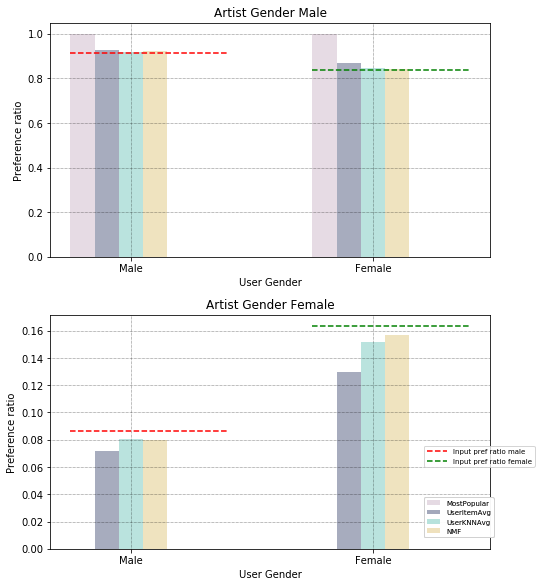

In [87]:
## plot preference changes for male user 
from matplotlib.font_manager import FontProperties

n_groups = 2
algo_names = ['MostPopular',
              'UserItemAvg',
              'UserKNNAvg',
              'NMF']


# create plot
fig = plt.figure(figsize=(7, 20))
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8
colours = ['#E0D3DE', '#9197AE', '#A9DDD6', '#ECDCB0', '#BCEBCB', '#BD9391']
colours_inputpr = ['r', 'g']
titles = ['Male', 'Female']
lines = []

for j in range(len(all_prefr_data)):
    for i in range(len(algo_names)):
        plt.subplot(5, 1, j+1)
        rects1 = plt.bar(index + bar_width*i, all_algo_prefr[j][i], bar_width,
        alpha=opacity,
        color=colours[i],
        label=algo_names[i])
    for i in index:
        # plot lines to represent pref ratios in data
        lines += plt.plot([-0.05 + i, i+bar_width*6], [all_prefr_data[j][i], all_prefr_data[j][i]], "k--", color=colours_inputpr[i])

    plt.xlabel('User Gender')
    plt.ylabel('Preference ratio')
    title = 'Artist Gender ' + titles[j] 
    plt.title(title)
    plt.xticks(index + bar_width*2, ('Male', 'Female', 'Undef'))
    
    if(j == 1):
        fontP = FontProperties()
        fontP.set_size('x-small')
        legend1 = plt.legend(lines, ["Input pref ratio male", 'Input pref ratio female'], handlelength=3, 
                              loc=(0.85,0.35),  prop=fontP)
        legend2 = plt.legend(prop=fontP,loc=(0.85,0.05)) 
        plt.gca().add_artist(legend1)
        plt.gca().add_artist(legend2)
    plt.grid(linestyle=':', linewidth='0.5', color='black')
    
plt.tight_layout()
#plt.savefig('pref-ratios2.png')
plt.show()

In [91]:
# Compute bias disparity:

# variables in inner lists stored in order: random, mostpop, userknn, userknnavg, nmf - results
male_bd = [[], [], []]   #user (m,f,null,nan) pref for male artist
female_bd = [[], [], []] #user (m,f,null,nan) pref for female artist
all_bd = [male_bd, female_bd]

# init variables
bias_disparity_results = {} #key1->algorithm name, item->matrix
pref_ratio_results #comparison to pref in data
a = 0 #algorithm name we consider

for rec_pref_ratios in all_rec_pref_ratio_results:
    algo_name = algo_names[a]
    
    bd = compute_bias_disparity(rec_pref_ratios, pref_ratio_results)
    bias_disparity_results[algo_name] = bd #store matrix in dict
    
    # DEBUG MESSAGES
    print('---------------------------------------------------')
    print('algorithm {} \n'.format(algo_name))
    print('user pref matrix:')
    print(pref_ratio_results, '\n')  
    print('pref_rec matrix:')
    print(rec_pref_ratios, '\n')    
    print('bd matrix')   
    print(bd)
    
    if algo_name != 'Random':
        # for each row in our matrix
        row_count = 0
        for r in bd:
            usergender_count = 0
            for i in r:
                #print('test:', all_bd[row_count][usergender_count])
                all_bd[row_count][usergender_count].append(i) 
                usergender_count += 1
            row_count += 1      
    a+=1 #next algorithm

---------------------------------------------------
algorithm Random 

user pref matrix:
[[0.91379641 0.83637134]
 [0.08620359 0.16362866]] 

pref_rec matrix:
[[0.86215488 0.85946736]
 [0.13784512 0.14053264]] 

bd matrix
[[-0.05651316  0.02761454]
 [ 0.59906468 -0.14114895]]
---------------------------------------------------
algorithm MostPopular 

user pref matrix:
[[0.91379641 0.83637134]
 [0.08620359 0.16362866]] 

pref_rec matrix:
[[1. 1.]
 [0. 0.]] 

bd matrix
[[ 0.09433566  0.19564116]
 [-1.         -1.        ]]
---------------------------------------------------
algorithm UserItemAvg 

user pref matrix:
[[0.91379641 0.83637134]
 [0.08620359 0.16362866]] 

pref_rec matrix:
[[0.92845466 0.86995703]
 [0.07154534 0.13004297]] 

bd matrix
[[ 0.01604105  0.04015643]
 [-0.17004228 -0.20525552]]
---------------------------------------------------
algorithm UserKNNAvg 

user pref matrix:
[[0.91379641 0.83637134]
 [0.08620359 0.16362866]] 

pref_rec matrix:
[[0.91941526 0.84824755]
 [0

In [56]:
all_bd

[[[-0.05651316427680059,
   0.0943356643356643,
   0.01604105174679255,
   0.006148906103392414,
   0.007120937200323372],
  [0.027614543316791994,
   0.19564115560060819,
   0.04015642694197843,
   0.014199675416519068,
   0.0080735383267267],
  []],
 [[0.5990646769149365,
   -1.0,
   -0.1700422831572522,
   -0.06518113956894818,
   -0.07548510153048385],
  [-0.14114894809334336,
   -1.0,
   -0.2052555190583514,
   -0.07258020620930551,
   -0.041267075436869895],
  []]]

/home/dshakes/enviroments/thesis/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


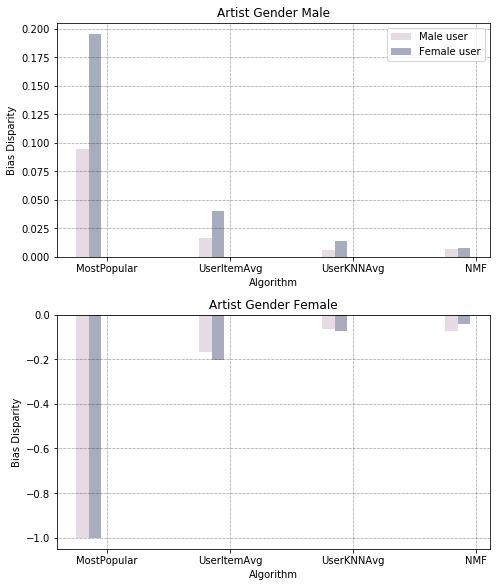

In [94]:
# create plot for bias disparity

fig = plt.figure(figsize=(7, 20))
n_groups = 4
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

colours_inputpr = ['r', 'g']
titles = ['Male', 'Female']


colours = ['#E0D3DE', '#9197AE', '#A9DDD6']
user_genders = ['Male user', 'Female user']

for j in range(len(all_bd)):
    for i in range(2):
        #print(i)
        plt.subplot(5, 1, j+1)
        #print(all_bd[j][i])
        rects1 = plt.bar(index + bar_width*i, all_bd[j][i], bar_width,
        alpha=opacity,
        color=colours[i],
        label=user_genders[i])
    
    plt.xlabel('Algorithm')
    plt.ylabel('Bias Disparity')
    title = 'Artist Gender ' + titles[j] 
    plt.title(title)
    plt.xticks(index + bar_width*2, ('MostPopular', 'UserItemAvg', 'UserKNNAvg', 'NMF'))
    
    if(j == 0):
        plt.legend()
    plt.grid(linestyle=':', linewidth='0.5', color='black')
    
plt.tight_layout()
#plt.savefig('bias-disparity.png')
plt.show()

### 4. Evaluation Against Testset

In [95]:
threshold = 242 # consider item as relevent if it has recieved a rating of >= 70 after log scaling

In [96]:
# recall@n 
def rn(topn, testset):
    U_rn = [] #r@n list for all users
    i = 0
    testset.columns = ['user', 'artist', 'playcount']
    df_testfold = testset

    
    for user_id, item_rec in topn.items():

        # collection of artist ids which are deemed 'relevent' in users listening history
        x = df_testfold[(df_testfold['user'] == user_id) & 
                        (df_testfold['playcount'] >= threshold)]['artist'].values.tolist()
        
        
        rec_test_unison = list(set(x) & set(item_rec))
        
        if len(x) == 0: rn = 0
        else: rn = len(rec_test_unison) / len(x)
            
        U_rn.append(rn)  
    return np.mean(U_rn)

In [97]:
# nDCG@n
def nDCGn(topn, testset):
    U_nDCGn = [] #ndcgn list for all users
    
    testset.columns = ['user', 'artist', 'playcount']
    df_testfold = testset

    for user_id, item_rec in topn.items():
        # collection of artist ids which are deemed 'relevent' in users listening history
        x = df_testfold[(df_testfold['user'] == user_id) & 
                        (df_testfold['playcount'] >= threshold)]['artist'].values.tolist()
             
        relevence_list = [1 if i in x else 0 for i in item_rec]
        ideal_list = np.sort(relevence_list)[::-1] #ideal list
        dcg_result = dcg(relevence_list)
        idcg_result = dcg(ideal_list)
        if dcg_result == 0 or idcg_result == 0:
            ndcgn = 0
        else: ndcgn = dcg_result/idcg_result
        U_nDCGn.append(ndcgn)      
    return np.mean(U_nDCGn) 

def dcg(rel_list):
    dcg_sum = 0
    for i, n in zip(rel_list, np.arange(len(rel_list))):
        dcg_sum += (np.power(2,i)-1)/np.log2((n+1)+1)
    return dcg_sum 

In [98]:
# p@n
def pn(topn, testset, n):
    U_pn = [] #p@n list for all users
    i = 0
    
    testset.columns = ['user', 'artist', 'playcount']
    df_testfold = testset
    
    #print(topn)

    for user_id, item_rec in topn.items():
        # collection of artist ids which are deemed 'relevent' in users listening history
        x = df_testfold[(df_testfold['user'] == user_id) & 
                        (df_testfold['playcount'] >= threshold)]['artist'].values.tolist()
        
        rec_test_unison = list(set(x) & set(item_rec))
        #print(rec_test_unison)
        pn = len(rec_test_unison) / n
        U_pn.append(pn)  
    return np.mean(U_pn)

In [99]:
# coverage@n
def cn(topn, testset):
    topn_unique_artists = set([j for sub in topn.values() for j in sub]) #all unique artist recommended in top n
    testset.columns = ['user', 'artist', 'playcount']
    df_testfold = testset
    testset_unique_artists = df_testfold['artist'].unique()    
    return len(topn_unique_artists)/len(testset_unique_artists)

In [100]:
def gn(topn, testset):
    testset.columns = ['user', 'artist', 'playcount']
    df_testfold = testset
    I = df_testfold['artist'].unique() #for consistency with the formal notation
    topn_artists = [j for sub in topn.values() for j in sub]
    #f = [i[0] for i in topn_artists]
    f = list(pd.Series(topn_artists).value_counts())
    
    zero_pad = np.zeros(len(I) - len(f)) #zero pad represents the freq count for items which were not recommended
    f.extend(zero_pad)
    f.reverse()

    numer = sum(f) #numerator   
    denom = 0 #denomonator
    for j in np.arange(len(I)):
        denom += (len(I) - j)*f[j] #note the +1 term is implied as we start at index 0, not 1    
    return (len(I)+1-(2*denom/numer))/ len(I)

In [101]:
def spread(topn, testset):
    testset.columns = ['user', 'artist', 'playcount']
    df_testfold = testset
    I = df_testfold['artist'].unique() #for consistency with the formal notation
    topn_artists = [j for sub in topn.values() for j in sub]
    #f = [i[0] for i in topn_artists]
    f = list(pd.Series(topn_artists).value_counts())
    count_I = sum(f) 
    p_i = [count_i / count_I for count_i in f]
    s_i = p_i * np.log2(p_i) #spread for each item
    s = - sum(s_i) #total spread
    return s

In [102]:
def epc(topn):
    topn_artists = [j for sub in topn.values() for j in sub]
    #f = [i[0] for i in topn_artists]
    f = list(pd.Series(topn_artists).value_counts())
    max_pop = f[0]
    normalised_pop = [1-(i/max_pop) for i in f]
    #print(normalised_pop)
    sum_pop = sum(normalised_pop)
    epc = sum_pop / len(f)
    return epc

In [103]:
def perc_lt(topn):
    #print('entering long tail function')
    

    topn_artists = [j for sub in topn.values() for j in sub]
    total = len(topn_artists) #number of recommendations made
    f = pd.Series(topn_artists).value_counts().to_frame() #frequency of artist recommendations
    
    # filter to only include values which are in the long tail
    f['artist'] = f.index
    f_filt = f[f['artist'].isin(lt_artists)]
    rec_lt = f_filt[0].sum()
    #print('longtperc:',rec_lt/total)
    return rec_lt/total

In [43]:


## Accuracy metric computation:
# (1) p@n
# (2) recall@n
# (3) nDCG@N
## Beyond accuracy metric computations:
# - Aggregate Diversity
# (1) coverage@n
# (2) gini
# (3) spread
# - Novelty
# (1) expected Popularity Complement
# (2) percentage of long-tail items

n = 10 #for each rec alg topn results = 10
algo_dicts = sample_algo_results_dfs
algo_test_sets = sample_algo_testset_dfs

for algo_name, rec_alg in algo_dicts.items():
        
    # accuracy results for each fold
    kfold_pn = []
    kfold_pn_m = []
    kfold_pn_f = []
    kfold_rn = []
    kfold_rn_m = []
    kfold_rn_f = []
    kfold_ndcgn = []
    kfold_ndcgn_m = []
    kfold_ndcgn_f = []
    
    # beyond accuracy - aggregate diveristy for each fold
    kfold_cn = []
    kfold_cn_m = []
    kfold_cn_f = []
    kfold_gn = []
    kfold_gn_m = []
    kfold_gn_f = []
    kfold_spread = []
    kfold_spread_m = []
    kfold_spread_f = []
    
    # beyond accuracy - novelity measures for each fold
    kfold_epc = []
    kfold_epc_m = []
    kfold_epc_f = []
    kfold_longtail = []
    kfold_longtail_m = []
    kfold_longtail_f = []
    
    # for each fold of kfold val.
    for k in range(num_folds):
        print('k =', k)
            
        topn_recs = rec_alg[k]
        topn_recs = topn_recs.groupby('user_id')['rec_artist'].apply(list).to_dict() #key = u_id, items = recommendations
        
        user_ids = topn_recs.keys()
  
        user_m_ids = list(set(m_user_ids) & set(user_ids))
        user_f_ids = list(set(f_user_ids) & set(user_ids))
        
        topn_recs_m = {key:value for (key,value) in topn_recs.items() if key in user_m_ids}
        topn_recs_f = {key:value for (key,value) in topn_recs.items() if key in user_f_ids}
        
        testset = algo_test_sets[algo_name][k]
        trainset = sample_algo_trainset_dfs[algo_name][k]

        patn = pn(topn_recs,testset,n)      #compute p@n for this fold
        patn_m = pn(topn_recs_m,testset,n)  
        patn_f = pn(topn_recs_f,testset,n)  
        
        ratn = rn(topn_recs,testset)        #compute r@n for this fold
        ratn_m = rn(topn_recs_m,testset)  
        ratn_f = rn(topn_recs_f,testset)   
        
        ndcgn = nDCGn(topn_recs,testset)    #compute nDCGn for this fold
        ndcgn_m = nDCGn(topn_recs_m,testset)
        ndcgn_f = nDCGn(topn_recs_f,testset)
        
        catn = cn(topn_recs,testset)        #compute c@n for this fold
        catn_m = cn(topn_recs_m,testset)    
        catn_f = cn(topn_recs_f,testset)    
        
        gatn = gn(topn_recs,testset)        #compute gini@n for this fold
        gatn_m = gn(topn_recs_m,testset)   
        gatn_f = gn(topn_recs_f,testset)        
                
        spreadn = spread(topn_recs,testset) #compute spread for this fold
        spreadn_m = spread(topn_recs_m,testset)
        spreadn_f = spread(topn_recs_f,testset) 
        
        epc_result = epc(topn_recs)         #compute epc for this fold
        epc_result_m = epc(topn_recs_m)       
        epc_result_f = epc(topn_recs_f)        
        
        longt_perc = perc_lt(topn_recs,trainset)     #compute long tail percentage for this fold
        longt_perc_m = perc_lt(topn_recs_m,trainset)   
        longt_perc_f = perc_lt(topn_recs_f,trainset)     
         
        kfold_pn.append(patn)
        kfold_pn_m.append(patn_m)
        kfold_pn_f.append(patn_f)
        
        kfold_rn.append(ratn)
        kfold_rn_m.append(ratn_m)
        kfold_rn_f.append(ratn_f)
    
        kfold_ndcgn.append(ndcgn)
        kfold_ndcgn_m.append(ndcgn_m)
        kfold_ndcgn_f.append(ndcgn_f)
        
        kfold_cn.append(catn)
        kfold_cn_m.append(catn_m)
        kfold_cn_f.append(catn_f)
            
        kfold_gn.append(gatn)
        kfold_gn_m.append(gatn_m)
        kfold_gn_f.append(gatn_f)
                
        kfold_spread.append(spreadn)
        kfold_spread_m.append(spreadn_m)
        kfold_spread_f.append(spreadn_f)
        
        kfold_epc.append(epc_result)
        kfold_epc_m.append(epc_result_m)
        kfold_epc_f.append(epc_result_f)
                
        kfold_longtail.append(longt_perc)
        kfold_longtail_m.append(longt_perc_m)
        kfold_longtail_f.append(longt_perc_f)
        
    # accuracy computations, average over each fold
    avg_pn = np.mean(kfold_pn)
    avg_pn_m = np.mean(kfold_pn_m)
    avg_pn_f = np.mean(kfold_pn_f)
        
    avg_rn = np.mean(kfold_rn)
    avg_rn_m = np.mean(kfold_rn_m)
    avg_rn_f = np.mean(kfold_rn_f)
                
    avg_ndcgn = np.mean(kfold_ndcgn)
    avg_ndcgn_m = np.mean(kfold_ndcgn_m)
    avg_ndcgn_f = np.mean(kfold_ndcgn_f)
    
    # beyond accuracy computations -aggregate diversity
    avg_cn = np.mean(kfold_cn)
    avg_cn_m = np.mean(kfold_cn_m)
    avg_cn_f = np.mean(kfold_cn_f)
                
    avg_gn = np.mean(kfold_gn)
    avg_gn_m = np.mean(kfold_gn_m)
    avg_gn_f = np.mean(kfold_gn_f)
                
    avg_spread = np.mean(kfold_spread)
    avg_spread_m = np.mean(kfold_spread_m)
    avg_spread_f = np.mean(kfold_spread_f)
    
    # beyond accuracy computations -novelity
    avg_epc = np.mean(kfold_epc)
    avg_epc_m = np.mean(kfold_epc_m)
    avg_epc_f = np.mean(kfold_epc_f)
                
    avg_lt_perc = np.mean(kfold_longtail)
    avg_lt_perc_m = np.mean(kfold_longtail_m)
    avg_lt_perc_f = np.mean(kfold_longtail_f)
    
    # average over all folds
    print('\n{} algo, avg p@n: {}'.format(algo_name, avg_pn)) 
    print('{} algo, avg p@n male: {}'.format(algo_name, avg_pn_m)) 
    print('{} algo, avg p@n: {}'.format(algo_name, avg_pn_f)) 
    
    print('{} algo, avg r@n: {}'.format(algo_name, avg_rn)) 
    print('{} algo, avg r@n male: {}'.format(algo_name, avg_rn_m)) 
    print('{} algo, avg r@n female: {}'.format(algo_name, avg_rn_f)) 
    
    print('{} algo, avg nDCG@n: {}'.format(algo_name,avg_ndcgn))
    print('{} algo, avg nDCG@n male: {}'.format(algo_name,avg_ndcgn_m)) 
    print('{} algo, avg nDCG@n female: {}'.format(algo_name,avg_ndcgn_f)) 

    print('{} algo, avg c@n: {}'.format(algo_name,avg_cn)) 
    print('{} algo, avg c@n male: {}'.format(algo_name,avg_cn_m))
    print('{} algo, avg c@n female: {}'.format(algo_name,avg_cn_f)) 
    
    print('{} algo, avg gini@n: {}'.format(algo_name,avg_gn)) 
    print('{} algo, avg gini@n male: {}'.format(algo_name,avg_gn_m)) 
    print('{} algo, avg gini@n female: {}'.format(algo_name,avg_gn_f)) 
    
    print('{} algo, avg spread: {}'.format(algo_name,avg_spread)) 
    print('{} algo, avg spread male: {}'.format(algo_name,avg_spread_m)) 
    print('{} algo, avg spread female: {}'.format(algo_name,avg_spread_f)) 
    
    print('{} algo, avg epc: {}'.format(algo_name,avg_epc)) 
    print('{} algo, avg epc male: {}'.format(algo_name,avg_epc_m))
    print('{} algo, avg epc female: {}'.format(algo_name,avg_epc_f))
    
    print('{} algo, avg longt: {}'.format(algo_name,avg_lt_perc)) 
    print('{} algo, avg longt male: {}'.format(algo_name,avg_lt_perc_m)) 
    print('{} algo, avg longt female: {}\n'.format(algo_name,avg_lt_perc_f)) 

k = 0
k = 1
k = 2

Random algo, avg p@n: 0.0009518391501252408
Random algo, avg p@n male: 0.0009646650625030421
Random algo, avg p@n: 0.0009168114263655665
Random algo, avg r@n: 6.706767689544847e-05
Random algo, avg r@n male: 7.007063773781113e-05
Random algo, avg r@n female: 5.8866507058070575e-05
Random algo, avg nDCG@n: 0.004228370020318932
Random algo, avg nDCG@n male: 0.004197938892977206
Random algo, avg nDCG@n female: 0.004311487771550563
Random algo, avg c@n: 0.6454654823063114
Random algo, avg c@n male: 0.5317848119944382
Random algo, avg c@n female: 0.24251276946319825
Random algo, avg gini@n: 0.5160141885276114
Random algo, avg gini@n male: 0.5841039175246344
Random algo, avg gini@n female: 0.7846361281469648
Random algo, avg spread: 16.12312439202918
Random algo, avg spread male: 15.869414569658375
Random algo, avg spread female: 14.811834826021732
Random algo, avg epc: 0.7800752440317532
Random algo, avg epc male: 0.7847682380361259
Random algo, avg epc female: 0.73253813

In [111]:
## Accuracy metric computation:
# (1) p@n
# (2) nDCG@N
## Beyond accuracy metric computations:
# - Aggregate Diversity
# (1) coverage@n
# (2) spread
# - Novelty
# (1) longtail perc.

eval_metrics = ['p@n', 'nDCG@N', 'c@n', 'spread', 'longtail_perc']
evaluation_dict = {a:{e:[] for e in eval_metrics} for a in algo_names}
evaluation_dict_m = {a:{e:[] for e in eval_metrics} for a in algo_names}
evaluation_dict_f = {a:{e:[] for e in eval_metrics} for a in algo_names}

n = 10 #for each rec alg topn results = 10
algo_dicts = sample_algo_results_dfs
algo_test_sets = sample_algo_testset_dfs

for algo_name, rec_alg in algo_dicts.items():
        
    # accuracy results for each fold
    kfold_pn = []
    kfold_pn_m = []
    kfold_pn_f = []

    kfold_ndcgn = []
    kfold_ndcgn_m = []
    kfold_ndcgn_f = []
    
    # beyond accuracy - aggregate diveristy for each fold
    kfold_cn = []
    kfold_cn_m = []
    kfold_cn_f = []

    kfold_spread = []
    kfold_spread_m = []
    kfold_spread_f = []
    
    # beyond accuracy - novelity measures for each fold

    kfold_longtail = []
    kfold_longtail_m = []
    kfold_longtail_f = []
    
    # for each fold of kfold val.
    for k in range(num_folds):
        print('k =', k)
            
        topn_recs = rec_alg[k]
        topn_recs = topn_recs.groupby('user_id')['rec_artist'].apply(list).to_dict() #key = u_id, items = recommendations
        
        user_ids = topn_recs.keys()
  
        user_m_ids = list(set(m_user_ids) & set(user_ids))
        user_f_ids = list(set(f_user_ids) & set(user_ids))
        
        topn_recs_m = {key:value for (key,value) in topn_recs.items() if key in user_m_ids}
        topn_recs_f = {key:value for (key,value) in topn_recs.items() if key in user_f_ids}
        
        testset = algo_test_sets[algo_name][k]
        trainset = sample_algo_trainset_dfs[algo_name][k]

        patn = pn(topn_recs,testset,n)      #compute p@n for this fold
        patn_m = pn(topn_recs_m,testset,n)  
        patn_f = pn(topn_recs_f,testset,n)  
        
        ndcgn = nDCGn(topn_recs,testset)    #compute nDCGn for this fold
        ndcgn_m = nDCGn(topn_recs_m,testset)
        ndcgn_f = nDCGn(topn_recs_f,testset)
        
        catn = cn(topn_recs,testset)        #compute c@n for this fold
        catn_m = cn(topn_recs_m,testset)    
        catn_f = cn(topn_recs_f,testset)            
                
        spreadn = spread(topn_recs,testset) #compute spread for this fold
        spreadn_m = spread(topn_recs_m,testset)
        spreadn_f = spread(topn_recs_f,testset)        
        
        longt_perc = perc_lt(topn_recs)     #compute long tail percentage for this fold
        longt_perc_m = perc_lt(topn_recs_m)   
        longt_perc_f = perc_lt(topn_recs_f)     
         
        kfold_pn.append(patn)
        kfold_pn_m.append(patn_m)
        kfold_pn_f.append(patn_f)
    
        kfold_ndcgn.append(ndcgn)
        kfold_ndcgn_m.append(ndcgn_m)
        kfold_ndcgn_f.append(ndcgn_f)
        
        kfold_cn.append(catn)
        kfold_cn_m.append(catn_m)
        kfold_cn_f.append(catn_f)
                
        kfold_spread.append(spreadn)
        kfold_spread_m.append(spreadn_m)
        kfold_spread_f.append(spreadn_f)
                
        kfold_longtail.append(longt_perc)
        kfold_longtail_m.append(longt_perc_m)
        kfold_longtail_f.append(longt_perc_f)
        
    # accuracy computations, average over each fold
    avg_pn = np.mean(kfold_pn)
    avg_pn_m = np.mean(kfold_pn_m)
    avg_pn_f = np.mean(kfold_pn_f)
    
    std_pn = np.std(kfold_pn)
    std_pn_m = np.std(kfold_pn_m)
    std_pn_f = np.std(kfold_pn_f)
                
    avg_ndcgn = np.mean(kfold_ndcgn)
    avg_ndcgn_m = np.mean(kfold_ndcgn_m)
    avg_ndcgn_f = np.mean(kfold_ndcgn_f)
    
    std_ndcgn = np.std(kfold_ndcgn)
    std_ndcgn_m = np.std(kfold_ndcgn_m)
    std_ndcgn_f = np.std(kfold_ndcgn_f)
    
    # beyond accuracy computations -aggregate diversity
    avg_cn = np.mean(kfold_cn)
    avg_cn_m = np.mean(kfold_cn_m)
    avg_cn_f = np.mean(kfold_cn_f)
    
    std_cn = np.std(kfold_cn)
    std_cn_m = np.std(kfold_cn_m)
    std_cn_f = np.std(kfold_cn_f)
                
    avg_spread = np.mean(kfold_spread)
    avg_spread_m = np.mean(kfold_spread_m)
    avg_spread_f = np.mean(kfold_spread_f)
    
    std_spread = np.std(kfold_spread)
    std_spread_m = np.std(kfold_spread_m)
    std_spread_f = np.std(kfold_spread_f)
                
    avg_lt_perc = np.mean(kfold_longtail)
    avg_lt_perc_m = np.mean(kfold_longtail_m)
    avg_lt_perc_f = np.mean(kfold_longtail_f)
    
    std_lt_perc = np.std(kfold_longtail)
    std_lt_perc_m = np.std(kfold_longtail_m)
    std_lt_perc_f = np.std(kfold_longtail_f)
    
    evaluation_dict[algo_name]['p@n'] = (avg_pn, std_pn)
    evaluation_dict[algo_name]['nDCG@N'] = (avg_ndcgn, std_ndcgn)
    evaluation_dict[algo_name]['c@n'] = (avg_cn, std_cn)
    evaluation_dict[algo_name]['spread'] = (avg_spread, std_spread)
    evaluation_dict[algo_name]['longtail_perc'] = (avg_lt_perc, std_lt_perc)
    
    evaluation_dict_m[algo_name]['p@n'] = (avg_pn_m, std_pn_m)
    evaluation_dict_m[algo_name]['nDCG@N'] = (avg_ndcgn_m, std_ndcgn_m)
    evaluation_dict_m[algo_name]['c@n'] = (avg_cn_m, std_cn_m)
    evaluation_dict_m[algo_name]['spread'] = (avg_spread_m, std_spread_m)
    evaluation_dict_m[algo_name]['longtail_perc'] = (avg_lt_perc_m, std_lt_perc_m)
    
    evaluation_dict_f[algo_name]['p@n'] = (avg_pn_f, std_pn_f)
    evaluation_dict_f[algo_name]['nDCG@N'] = (avg_ndcgn_f, std_ndcgn_f)
    evaluation_dict_f[algo_name]['c@n'] = (avg_cn_f, std_cn_f)
    evaluation_dict_f[algo_name]['spread'] = (avg_spread_f, std_spread_f)
    evaluation_dict_f[algo_name]['longtail_perc'] = (avg_lt_perc_f, std_lt_perc_f)
    
    print('\n{} algo, avg p@n: {}'.format(algo_name, avg_pn)) 
    print('{} algo, avg p@n male: {}'.format(algo_name, avg_pn_m)) 
    print('{} algo, avg p@n: {}'.format(algo_name, avg_pn_f)) 
    
    print('{} algo, avg nDCG@n: {}'.format(algo_name,avg_ndcgn))
    print('{} algo, avg nDCG@n male: {}'.format(algo_name,avg_ndcgn_m)) 
    print('{} algo, avg nDCG@n female: {}'.format(algo_name,avg_ndcgn_f)) 

    print('{} algo, avg c@n: {}'.format(algo_name,avg_cn)) 
    print('{} algo, avg c@n male: {}'.format(algo_name,avg_cn_m))
    print('{} algo, avg c@n female: {}'.format(algo_name,avg_cn_f)) 
    
    print('{} algo, avg spread: {}'.format(algo_name,avg_spread)) 
    print('{} algo, avg spread male: {}'.format(algo_name,avg_spread_m)) 
    print('{} algo, avg spread female: {}'.format(algo_name,avg_spread_f)) 
    
    print('{} algo, avg longt: {}'.format(algo_name,avg_lt_perc)) 
    print('{} algo, avg longt male: {}'.format(algo_name,avg_lt_perc_m)) 
    print('{} algo, avg longt female: {}\n'.format(algo_name,avg_lt_perc_f)) 

k = 0
k = 1
k = 2

Random algo, avg p@n: 0.000688820908165517
Random algo, avg p@n male: 0.0006734006734006734
Random algo, avg p@n: 0.0007395910322739592
Random algo, avg nDCG@n: 0.0035299915638531128
Random algo, avg nDCG@n male: 0.0033606300381156576
Random algo, avg nDCG@n female: 0.004087956215161425
Random algo, avg c@n: 0.865269964360894
Random algo, avg c@n male: 0.7840255677882372
Random algo, avg c@n female: 0.37399385699942994
Random algo, avg spread: 12.818406916065811
Random algo, avg spread male: 12.682791730808967
Random algo, avg spread female: 11.70834589553148
Random algo, avg longt: 0.7299471191833771
Random algo, avg longt male: 0.7292929292929293
Random algo, avg longt female: 0.7320988749281433

k = 0
k = 1
k = 2

MostPopular algo, avg p@n: 0.027900064141674882
MostPopular algo, avg p@n male: 0.029369423259059866
MostPopular algo, avg p@n: 0.023059866962305987
MostPopular algo, avg nDCG@n: 0.10685037729860071
MostPopular algo, avg nDCG@n male: 0.11109372102819946


### Compute statistical relevence

In [128]:
def test_hypothesis(mean_x1, mean_x2, s1, s2, n1, n2):
    s1 = np.power(s1, 2) / n1
    s2 = np.power(s2, 2) / n2
    return np.abs((mean_x1-mean_x2)/np.sqrt(s1+s2))

In [129]:
for eval_m in eval_metrics:
    i = 1
    for algo in algo_names:
        
        evaluation_dict[algo]
        avg_m1 = evaluation_dict[algo][eval_m][0]
        std_m1 = evaluation_dict[algo][eval_m][1]
        print('\n{} average {}: {}\n'.format(algo, eval_m, avg_m1))
        
        for algo2 in algo_names[i:]:
            avg_m2 = evaluation_dict[algo2][eval_m][0]
            std_m2 = evaluation_dict[algo2][eval_m][1]
            
            
            print('{} average {}: {}'.format(algo2, eval_m, avg_m2))
            
            # tvalue
            t = test_hypothesis(avg_m1, avg_m2, std_m1, std_m2, 3, 3)
            print('\n- {} - {} t value: {}\n'.format(algo,algo2,t))
        i+=1   
    print('\n')


Random average p@n: 0.000688820908165517

MostPopular average p@n: 0.027900064141674882

- Random - MostPopular t value: 68.38545006961513

UserItemAvg average p@n: 0.39568015241825494

- Random - UserItemAvg t value: 552.2245584409008

UserKNNAvg average p@n: 0.3991906733064841

- Random - UserKNNAvg t value: 2100.905713242828

NMF average p@n: 0.4431027861418982

- Random - NMF t value: 390.5111422532156


MostPopular average p@n: 0.027900064141674882

UserItemAvg average p@n: 0.39568015241825494

- MostPopular - UserItemAvg t value: 449.46413846449303

UserKNNAvg average p@n: 0.3991906733064841

- MostPopular - UserKNNAvg t value: 843.149056321733

NMF average p@n: 0.4431027861418982

- MostPopular - NMF t value: 345.83124351487015


UserItemAvg average p@n: 0.39568015241825494

UserKNNAvg average p@n: 0.3991906733064841

- UserItemAvg - UserKNNAvg t value: 4.745673130153085

NMF average p@n: 0.4431027861418982

- UserItemAvg - NMF t value: 35.39882006017399


UserKNNAvg average p@